# TFM: Predicción de la demanda energética - Parte 2: EDA y preprocesamiento de los datos
#### Lara Palacios
## 0. Importación de librerías

(Librerías de análisis de series temporales:
- Sktime
- Darts
- AutoTS
- Prophet
- Kats
- tsfresh)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

## 2. Análisis inicial de los datos (EDA)

### 2.1. Archivo cupsInfo (información de cliente y de contrato)

In [2]:
df_info = pd.read_csv('cupsInfo.csv').reset_index(drop = True)
df_info.shape

(11786, 16)

In [3]:
df_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11786 entries, 0 to 11785
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PK_CLIENTE              11786 non-null  int64  
 1   TARIFA                  11786 non-null  int64  
 2   MUNICIPIO               11786 non-null  int64  
 3   PROVINCIA               11786 non-null  int64  
 4   KW_CONTRATADA_P1        11786 non-null  float64
 5   KW_CONTRATADA_P2        11786 non-null  float64
 6   KW_CONTRATADA_P3        11786 non-null  float64
 7   KW_CONTRATADA_P4        11786 non-null  float64
 8   KW_CONTRATADA_P5        11786 non-null  float64
 9   KW_CONTRATADA_P6        11786 non-null  float64
 10  AUTOCONSUMO             11786 non-null  int64  
 11  POTENCIA_GENERACION_KW  11786 non-null  float64
 12  ESQUEMA_MEDIDA          11782 non-null  object 
 13  SUBGRUPO                11736 non-null  object 
 14  ALTA_AUTOCONSUMO        11786 non-null

En nuestro conjunto de datos, tenemos información de 11786 clientes.

In [4]:
total_cli = len(df_info.MUNICIPIO.unique())
total_cli

2348

In [4]:
total_cli = len(df_info.PK_CLIENTE.unique())
total_cli

11786

In [5]:
df_info.isnull().sum() #qué hacer con los nulos de las variables categóricas? coger la moda?

PK_CLIENTE                 0
TARIFA                     0
MUNICIPIO                  0
PROVINCIA                  0
KW_CONTRATADA_P1           0
KW_CONTRATADA_P2           0
KW_CONTRATADA_P3           0
KW_CONTRATADA_P4           0
KW_CONTRATADA_P5           0
KW_CONTRATADA_P6           0
AUTOCONSUMO                0
POTENCIA_GENERACION_KW     0
ESQUEMA_MEDIDA             4
SUBGRUPO                  50
ALTA_AUTOCONSUMO           0
BAJA_AUTOCONSUMO           0
dtype: int64

In [6]:
df_info.head()

,PK_CLIENTE,TARIFA,MUNICIPIO,PROVINCIA,KW_CONTRATADA_P1,KW_CONTRATADA_P2,KW_CONTRATADA_P3,KW_CONTRATADA_P4,KW_CONTRATADA_P5,KW_CONTRATADA_P6,AUTOCONSUMO,POTENCIA_GENERACION_KW,ESQUEMA_MEDIDA,SUBGRUPO,ALTA_AUTOCONSUMO,BAJA_AUTOCONSUMO
0,1,18,1001,1,4.0,4.0,0.0,0.0,0.0,0.0,41,4.00,A,b.1.1,2021-06-01,3000-01-01 00:00:00
1,2,19,1001,1,57.0,85.0,85.0,85.0,85.0,178.0,41,100.00,A,b.1.1,2022-06-30,3000-01-01 00:00:00
2,3,18,1002,1,4.4,4.4,0.0,0.0,0.0,0.0,41,6.00,A,b.1.1,2022-06-29,3000-01-01 00:00:00
3,4,18,1010,1,3.5,3.5,0.0,0.0,0.0,0.0,41,1.52,A,b.1.1,2022-03-05,3000-01-01 00:00:00
4,5,19,1004,1,60.0,60.0,60.0,60.0,60.0,60.0,41,44.00,A,b.1.1,2022-12-01,3000-01-01 00:00:00


Formateamos las variables y las categorizamos en numéricas, categóricas o fechas. Además notar que la columna 'PK_CLIENTE' es un identificador único que identifica al cliente y no se considerará una variable con poder predictivo.

#### Variables categóricas

In [7]:
df_info['TARIFA'] = df_info['TARIFA'].astype('category')
df_info['MUNICIPIO'] = df_info['MUNICIPIO'].astype('category')
df_info['PROVINCIA'] = df_info['PROVINCIA'].astype('category')
df_info['AUTOCONSUMO'] = df_info['AUTOCONSUMO'].astype('category')
df_info['ESQUEMA_MEDIDA'] = df_info['ESQUEMA_MEDIDA'].astype('category')
df_info['SUBGRUPO'] = df_info['SUBGRUPO'].astype('category')

In [8]:
df_info_categoricas = df_info[df_info.select_dtypes(include=['category']).columns]

In [9]:
df_info_categoricas.describe()

,TARIFA,MUNICIPIO,PROVINCIA,AUTOCONSUMO,ESQUEMA_MEDIDA,SUBGRUPO
count,11786,11786,11786,11786,11782,11736
unique,5,2348,50,11,5,9
top,18,8205,8,41,A,b.1.1
freq,11125,122,3315,11480,11510,10485


- TARIFA: Se observa que la variable vale lo mismo para casi todos los clientes.

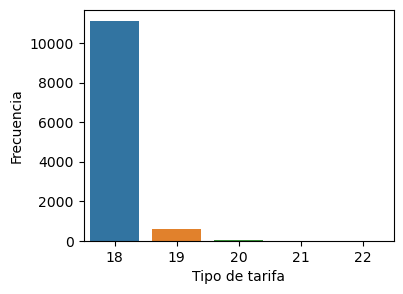

In [10]:
frecuencias = df_info['TARIFA'].value_counts()

plt.figure(figsize=(4, 3))
sns.barplot(x = "index", y = "TARIFA", data = frecuencias.reset_index())
plt.xlabel('Tipo de tarifa')
plt.ylabel('Frecuencia')
plt.show()

- MUNICIPIO: En nuestro conjunto de datos contamos con 2348 municipios distintos. Es una variable categórica demasiado grande, por lo que seguramente acabemos tomando como referencia la variable PROVINCIA (que es un superconjunto de la variable MUNICIPIO).

- PROVINCIA: Vemos que las más frecuentes son: Barcelona(8), Girona(17), Valencia(46), Madrid(28) e Islas Baleares(7).

In [11]:
frecuencias = df_info['PROVINCIA'].value_counts()
frecuencias.head()

8     3315
17    1239
46     661
28     644
7      545
Name: PROVINCIA, dtype: int64

- AUTOCONSUMO: Se observa que la variable vale lo mismo para casi todos los clientes.

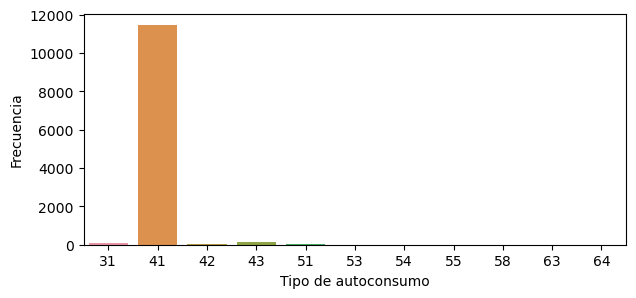

In [12]:
frecuencias = df_info['AUTOCONSUMO'].value_counts()

plt.figure(figsize=(7, 3))
sns.barplot(x = "index", y = "AUTOCONSUMO", data = frecuencias.reset_index())
plt.xlabel('Tipo de autoconsumo')
plt.ylabel('Frecuencia')
plt.show()

- ESQUEMA_MEDIDA: Se observa que la variable vale lo mismo para casi todos los clientes.

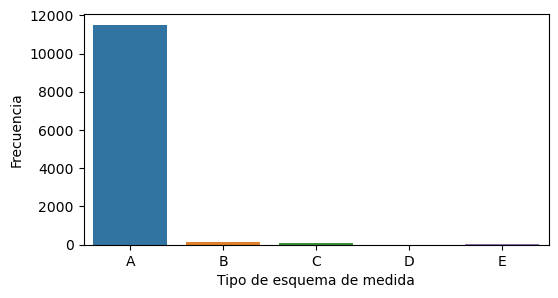

In [13]:
frecuencias = df_info['ESQUEMA_MEDIDA'].value_counts()

plt.figure(figsize=(6, 3))
sns.barplot(x = "index", y = "ESQUEMA_MEDIDA", data = frecuencias.reset_index())
plt.xlabel('Tipo de esquema de medida')
plt.ylabel('Frecuencia')
plt.show()

- SUBGRUPO: Se observa que la variable vale lo mismo para casi todos los clientes.

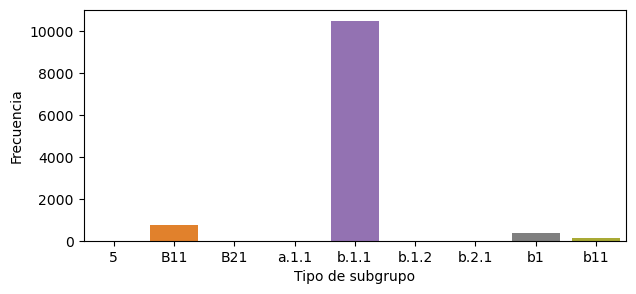

In [14]:
frecuencias = df_info['SUBGRUPO'].value_counts()

plt.figure(figsize=(7, 3))
sns.barplot(x = "index", y = "SUBGRUPO", data = frecuencias.reset_index())
plt.xlabel('Tipo de subgrupo')
plt.ylabel('Frecuencia')
plt.show()

#### Variables numéricas

In [15]:
df_info_numericas = df_info[df_info.select_dtypes(include=['float64']).columns]

In [16]:
df_info_numericas.describe()

,KW_CONTRATADA_P1,KW_CONTRATADA_P2,KW_CONTRATADA_P3,KW_CONTRATADA_P4,KW_CONTRATADA_P5,KW_CONTRATADA_P6,POTENCIA_GENERACION_KW
count,11786.000000,11786.000000,11786.000000,11786.000000,11786.000000,11786.000000,11786.000000
mean,7.492712,7.733908,2.504065,2.498043,2.502116,3.024904,6.999336
std,22.531164,22.810726,23.328087,23.326758,23.354755,26.258712,72.623960
min,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.400000,4.400000,0.000000,0.000000,0.000000,0.000000,3.000000
50%,5.000000,5.200000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,6.600000,6.900000,0.000000,0.000000,0.000000,0.000000,5.000000
max,1550.000000,1550.000000,1550.000000,1550.000000,1550.000000,1550.000000,4225.000000


- KW_CONTRATADA_Pi: Al no tener definidos los rangos de valores que toma cada una, se desestiman estos datos.

- POTENCIA_GENERACION_KW: vemos que los valores que toma esta variable son inferiores a 10, salvo en determinados casos que pasa hasta de los 4000.

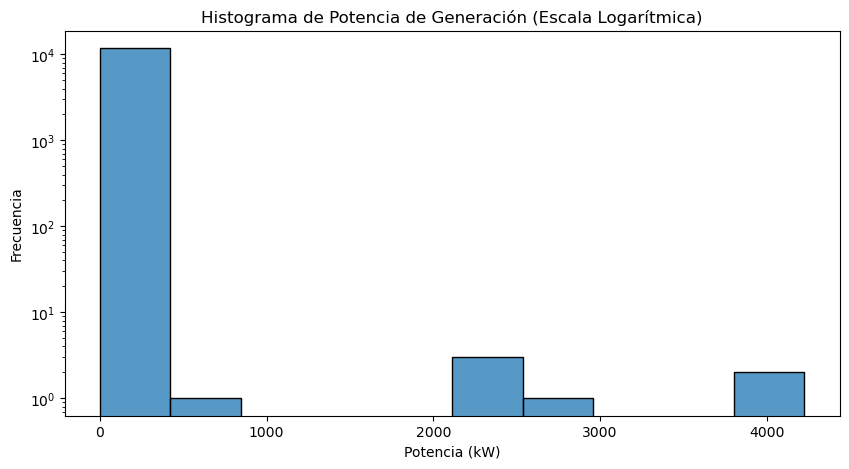

In [17]:
plt.figure(figsize=(10, 5))

sns.histplot(df_info['POTENCIA_GENERACION_KW'], bins=10, kde=False)
plt.yscale('log')
plt.title('Histograma de Potencia de Generación (Escala Logarítmica)')
plt.xlabel('Potencia (kW)')
plt.ylabel('Frecuencia')

plt.show()

#### Variables tipo datetime

Como el tipo de datos datetime de pandas no soporta más allá de la fecha 2262-04-11, a todas aquellas fechas superiores a este máximo las convertiremos en 2200-01-01.

In [18]:
df_info['BAJA_AUTOCONSUMO'] = df_info['BAJA_AUTOCONSUMO'].replace('3000-01-01 00:00:00', '2200-01-01 00:00:00')

In [66]:
df_info['ALTA_AUTOCONSUMO'] = pd.to_datetime(df_info['ALTA_AUTOCONSUMO'])
df_info['BAJA_AUTOCONSUMO'] = pd.to_datetime(df_info['BAJA_AUTOCONSUMO'])

In [72]:
df_info_datetime = df_info[['ALTA_AUTOCONSUMO', 'BAJA_AUTOCONSUMO']]

In [80]:
df_info_datetime.describe(datetime_is_numeric=True)

,ALTA_AUTOCONSUMO,BAJA_AUTOCONSUMO
count,11786,11786
mean,2021-10-27 01:01:05.365688064,2199-12-15 11:35:26.522992640
min,2013-03-22 00:00:00,2021-08-24 00:00:00
25%,2021-04-09 06:00:00,2200-01-01 00:00:00
50%,2021-12-23 00:00:00,2200-01-01 00:00:00
75%,2022-07-06 00:00:00,2200-01-01 00:00:00
max,2023-01-04 00:00:00,2200-01-01 00:00:00


- ALTA_AUTOCONSUMO: Se observa una tendencia creciente entre el intervalo de tiempo 2020 - 2022.

Representemos los valores de esta variable en una gráfica sin otuliers para poder hacernos una idea mejor de cómo es.

Para eliminar los outliers utilizamos el Método del Rango Intercuartílico (IQR), el cuál utiliza los cuartiles para identificar valores atípicos en una distribución.

In [22]:
Q1 = df_info['ALTA_AUTOCONSUMO'].quantile(0.25)
Q3 = df_info['ALTA_AUTOCONSUMO'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

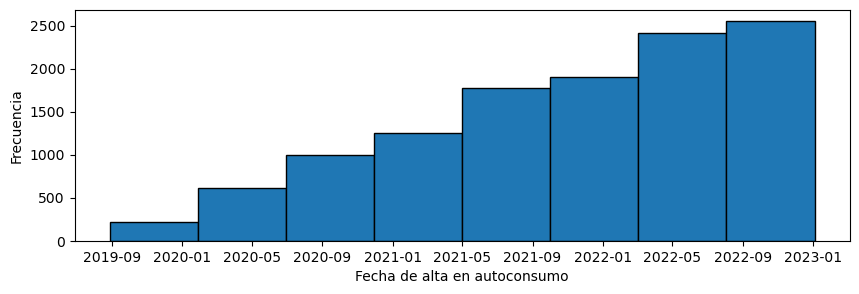

In [23]:
df_filtrado = df_info[(df_info['ALTA_AUTOCONSUMO'] >= limite_inferior) & (df_info['ALTA_AUTOCONSUMO'] <= limite_superior)]

plt.figure(figsize=(10, 3))
plt.hist(df_filtrado['ALTA_AUTOCONSUMO'], bins=8, edgecolor='black')
plt.xlabel('Fecha de alta en autoconsumo')
plt.ylabel('Frecuencia')
plt.show()

Notar que hay fechas de alta en autoconsumo más recientes que las fechas que trataremos en la serie temporal. Se comprueba más adelante.

- BAJA_AUTOCONSUMO: Notar que casi el 100% de los clientes no han sido dados de baja en autoconsumo.

In [24]:
val_mas_frec = (df_info['BAJA_AUTOCONSUMO'] == df_info['BAJA_AUTOCONSUMO'].mode()[0]).sum()

(val_mas_frec/total_cli)*100

99.97454607161038

### 2.2. Archivos cups (consumo)

In [25]:
df_consumo = pd.read_parquet('cups.parquet').reset_index(drop = True)
df_consumo.shape

(17396856, 5)

In [26]:
df_consumo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17396856 entries, 0 to 17396855
Data columns (total 5 columns):
 #   Column         Dtype         
---  ------         -----         
 0   PK_CLIENTE     int64         
 1   PK_ANYOMESDIA  datetime64[ns]
 2   PK_HORA        int64         
 3   ENTRADA        float64       
 4   SALIDA         float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 663.6 MB


Casi el 10% de los registros son nulos. Se establece eliminar estos registros del análisis.

In [27]:
df_consumo.isnull().sum()

PK_CLIENTE             0
PK_ANYOMESDIA          0
PK_HORA                0
ENTRADA          1612265
SALIDA           1612288
dtype: int64

In [28]:
df_consumo = df_consumo.dropna().reset_index(drop = True)
df_consumo.shape

(15784568, 5)

In [29]:
df_consumo.head()

,PK_CLIENTE,PK_ANYOMESDIA,PK_HORA,ENTRADA,SALIDA
0,1,2023-01-07,0,0.471,0.0
1,1,2023-01-07,1,0.393,0.0
2,1,2023-01-07,2,0.331,0.0
3,1,2023-01-07,3,0.413,0.0
4,1,2023-01-07,4,0.354,0.0


In [30]:
total_cli = len(df_consumo.PK_CLIENTE.unique())
total_cli

11603

Notar que este conjunto de datos es el que representa a la serie temporal 'pura', y el resto de conjuntos de datos se podrán añadir al modelo como variables exógenas.

Además, ya podemos comprobar cuantos clientes tienen una fecha de alta en autoconsumo más reciente al inicio de la serie temporal:

In [79]:
df_info[df_info['ALTA_AUTOCONSUMO'] > df_consumo['PK_ANYOMESDIA'].min()].shape

(474, 16)

### 2.3. Archivos tiempo

In [31]:
df_tiempo = pd.read_parquet('tiempo.parquet').reset_index(drop = True)
df_tiempo.shape

(17084345, 16)

Guardamos los datos a nivel municipio, en vez de a nivel cliente:

In [32]:
df_tiempo = df_tiempo.drop(columns = 'PK_CLIENTE').drop_duplicates().sort_values(by = ['MUNICIPIO', 'PK_ANYOMESDIA', 'PK_HORA'], ascending = [True, True, True]).reset_index(drop = True)
df_tiempo.shape

(3266814, 15)

In [33]:
df_tiempo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3266814 entries, 0 to 3266813
Data columns (total 15 columns):
 #   Column                Dtype         
---  ------                -----         
 0   PK_ANYOMESDIA         datetime64[ns]
 1   PK_HORA               float64       
 2   MUNICIPIO             object        
 3   ORTO                  object        
 4   OCASO                 object        
 5   NIEVE                 object        
 6   ESTADO_CIELO          object        
 7   DESCRIPCION           object        
 8   SENS_TERMICA          float64       
 9   TEMPERATURA           float64       
 10  PRECIPITACION         object        
 11  HUMEDAD_RELATIVA      object        
 12  VIENTO_DIRECCION      object        
 13  VIENTO_VELOCIDAD      object        
 14  VIENTO_AND_RACHA_MAX  object        
dtypes: datetime64[ns](1), float64(3), object(11)
memory usage: 373.9+ MB


In [34]:
df_tiempo['PK_HORA'] = df_tiempo['PK_HORA'].astype('int64')

In [35]:
df_tiempo['MUNICIPIO'] = df_tiempo['MUNICIPIO'].astype('int64')
df_tiempo['MUNICIPIO'] = df_tiempo['MUNICIPIO'].astype('category')

In [36]:
df_tiempo.isnull().sum()

PK_ANYOMESDIA           0
PK_HORA                 0
MUNICIPIO               0
ORTO                    0
OCASO                   0
NIEVE                   0
ESTADO_CIELO            0
DESCRIPCION             0
SENS_TERMICA            0
TEMPERATURA             0
PRECIPITACION           0
HUMEDAD_RELATIVA        0
VIENTO_DIRECCION        0
VIENTO_VELOCIDAD        0
VIENTO_AND_RACHA_MAX    0
dtype: int64

In [58]:
df_tiempo

,PK_ANYOMESDIA,PK_HORA,MUNICIPIO,ORTO,OCASO,NIEVE,ESTADO_CIELO,DESCRIPCION,SENS_TERMICA,TEMPERATURA,PRECIPITACION,HUMEDAD_RELATIVA,VIENTO_DIRECCION,VIENTO_VELOCIDAD,VIENTO_AND_RACHA_MAX
0,2022-11-09,0,1001,07:53,17:53,0.0,46n,Cubierto con lluvia escasa,13.0,13.0,0.1,75,SO,21,31
1,2022-11-09,1,1001,07:53,17:53,0.0,17n,Nubes altas,13.0,13.0,0.0,79,SO,20,27
2,2022-11-09,2,1001,07:53,17:53,0.0,16n,Cubierto,13.0,13.0,0.0,80,SO,19,23
3,2022-11-09,3,1001,07:53,17:53,0.0,16n,Cubierto,13.0,13.0,0.0,80,SO,16,33
4,2022-11-09,4,1001,07:53,17:53,0.0,16n,Cubierto,13.0,13.0,0.0,76,SO,23,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3266809,2023-01-10,8,50297,08:29,17:52,0.0,12n,Poco nuboso,4.0,4.0,0.0,79,N,6,16
3266810,2023-01-10,9,50297,08:29,17:52,0.0,12,Poco nuboso,2.0,5.0,0.0,81,NO,11,12
3266811,2023-01-10,10,50297,08:29,17:52,0.0,11,Despejado,6.0,6.0,0.0,86,N,6,6
3266812,2023-01-10,11,50297,08:29,17:52,0.0,11,Despejado,7.0,7.0,0.0,78,O,3,17


Observamos que tenemos un histórico de dos meses para nuestra serie temporal.

In [38]:
total_muni = len(df_tiempo.MUNICIPIO.unique())
total_muni

2162

Formateamos las variables y las categorizamos en numéricas, categóricas o fechas.

#### Variables categóricas

In [39]:
df_tiempo['ESTADO_CIELO'] = df_tiempo['ESTADO_CIELO'].astype('category')
df_tiempo['DESCRIPCION'] = df_tiempo['DESCRIPCION'].astype('category')
df_tiempo['VIENTO_DIRECCION'] = df_tiempo['VIENTO_DIRECCION'].astype('category')

In [40]:
df_tiempo_categoricas = df_tiempo[df_tiempo.select_dtypes(include=['category']).columns]

In [41]:
df_tiempo_categoricas.describe()

,MUNICIPIO,ESTADO_CIELO,DESCRIPCION,VIENTO_DIRECCION
count,3266814,3266814,3266814,3266814
unique,2162,64,32,9
top,47007,11n,Despejado,O
freq,1543,486622,815250,656024


- VIENTO_DIRECCION

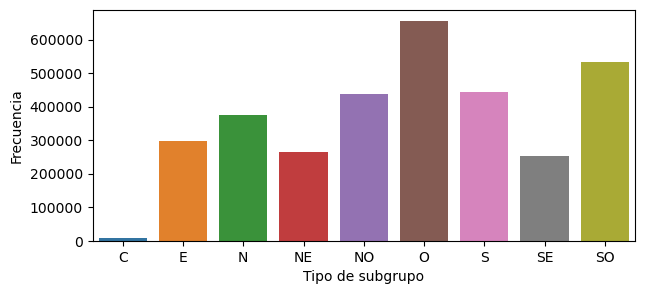

In [42]:
frecuencias = df_tiempo['VIENTO_DIRECCION'].value_counts()

plt.figure(figsize=(7, 3))
sns.barplot(x = "index", y = "VIENTO_DIRECCION", data = frecuencias.reset_index())
plt.xlabel('Tipo de subgrupo')
plt.ylabel('Frecuencia')
plt.show()

#### Variables numéricas

Reemplazamos los valores 'lp' (low precision) que aparecen en el dataframe mediante su reemplazo por 0.1, ya que corresponden a variables numéricas.

In [43]:
columnas_con_ip = df_tiempo.columns[df_tiempo.isin(['Ip']).any()]

print(f"El valor 'Ip' está presente en las siguientes columnas: {columnas_con_ip}")

El valor 'Ip' está presente en las siguientes columnas: Index(['NIEVE', 'PRECIPITACION'], dtype='object')


In [44]:
df_tiempo[columnas_con_ip] = df_tiempo[columnas_con_ip].replace('Ip', 0.1)

In [45]:
df_tiempo['VIENTO_AND_RACHA_MAX'] = df_tiempo['VIENTO_AND_RACHA_MAX'].replace('0.0', '0')

In [46]:
df_tiempo['NIEVE'] = df_tiempo['NIEVE'].astype(float)
df_tiempo['SENS_TERMICA'] = df_tiempo['SENS_TERMICA'].astype(float)
df_tiempo['TEMPERATURA'] = df_tiempo['TEMPERATURA'].astype(float)
df_tiempo['PRECIPITACION'] = df_tiempo['PRECIPITACION'].astype(float)
df_tiempo['HUMEDAD_RELATIVA'] = df_tiempo['HUMEDAD_RELATIVA'].astype('int64')
df_tiempo['VIENTO_VELOCIDAD'] = df_tiempo['VIENTO_VELOCIDAD'].astype('int64')
df_tiempo['VIENTO_AND_RACHA_MAX'] = df_tiempo['VIENTO_AND_RACHA_MAX'].astype('int64')

In [47]:
df_tiempo_numericas = df_tiempo[df_tiempo.select_dtypes(include=['float64', 'int64']).columns].drop(columns = 'PK_HORA')

In [48]:
df_tiempo_numericas.describe()

,NIEVE,SENS_TERMICA,TEMPERATURA,PRECIPITACION,HUMEDAD_RELATIVA,VIENTO_VELOCIDAD,VIENTO_AND_RACHA_MAX
count,3.266814e+06,3.266814e+06,3.266814e+06,3.266814e+06,3.266814e+06,3.266814e+06,3.266814e+06
mean,1.314737e-04,1.079331e+01,1.114824e+01,7.599637e-02,7.657814e+01,1.008238e+01,1.688299e+01
std,7.368554e-03,5.034277e+00,4.600981e+00,4.798044e-01,1.647640e+01,7.463382e+00,1.219562e+01
min,0.000000e+00,-1.200000e+01,-1.000000e+01,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,7.000000e+00,8.000000e+00,0.000000e+00,6.600000e+01,5.000000e+00,8.000000e+00
50%,0.000000e+00,1.100000e+01,1.100000e+01,0.000000e+00,7.900000e+01,8.000000e+00,1.300000e+01
75%,0.000000e+00,1.400000e+01,1.400000e+01,0.000000e+00,8.900000e+01,1.300000e+01,2.200000e+01
max,4.000000e+00,3.000000e+01,2.900000e+01,3.800000e+01,1.000000e+02,9.700000e+01,1.450000e+02


- NIEVE: Toma valores entre 0 y 4 metros cúbicos. También se puede observar que al menos el 75% de registros de esta columna valen 0.

- SENS_TERMICA: Toma valores de entre -12 y 30 grados.

- TEMPERATURA: Vemos que la temperatura tiene unas estadísticas bastante parecidas a las de la sensación térmica.

- PRECIPITACION: Toma valores entre 0 y 38 metros cúbicos. También se puede observar que al menos el 75% de registros de esta columna valen 0.

#### Variables tipo datetime

In [184]:
#datetime = orto, ocaso

## 3. Preparación de los datos e ingeniería de características

### 3.1. Concatenación de los distintos dataframes

In [81]:
df_aux = df_consumo.merge(df_info, on="PK_CLIENTE", how="inner")
df_aux.shape

(15784568, 20)

In [82]:
df_aux.isna().sum()

PK_CLIENTE                    0
PK_ANYOMESDIA                 0
PK_HORA                       0
ENTRADA                       0
SALIDA                        0
TARIFA                        0
MUNICIPIO                     0
PROVINCIA                     0
KW_CONTRATADA_P1              0
KW_CONTRATADA_P2              0
KW_CONTRATADA_P3              0
KW_CONTRATADA_P4              0
KW_CONTRATADA_P5              0
KW_CONTRATADA_P6              0
AUTOCONSUMO                   0
POTENCIA_GENERACION_KW        0
ESQUEMA_MEDIDA             4408
SUBGRUPO                  62482
ALTA_AUTOCONSUMO              0
BAJA_AUTOCONSUMO              0
dtype: int64

In [83]:
df = df_aux.merge(df_tiempo, on=["MUNICIPIO", "PK_ANYOMESDIA", "PK_HORA"], how="inner")
df.shape

(15140750, 32)

In [84]:
df.isna().sum()

PK_CLIENTE                    0
PK_ANYOMESDIA                 0
PK_HORA                       0
ENTRADA                       0
SALIDA                        0
TARIFA                        0
MUNICIPIO                     0
PROVINCIA                     0
KW_CONTRATADA_P1              0
KW_CONTRATADA_P2              0
KW_CONTRATADA_P3              0
KW_CONTRATADA_P4              0
KW_CONTRATADA_P5              0
KW_CONTRATADA_P6              0
AUTOCONSUMO                   0
POTENCIA_GENERACION_KW        0
ESQUEMA_MEDIDA             4408
SUBGRUPO                  54304
ALTA_AUTOCONSUMO              0
BAJA_AUTOCONSUMO              0
ORTO                          0
OCASO                         0
NIEVE                         0
ESTADO_CIELO                  0
DESCRIPCION                   0
SENS_TERMICA                  0
TEMPERATURA                   0
PRECIPITACION                 0
HUMEDAD_RELATIVA              0
VIENTO_DIRECCION              0
VIENTO_VELOCIDAD              0
VIENTO_A

Le damos un poco de formato a los campos más importantes:

In [85]:
df = df.sort_values(by=['PK_ANYOMESDIA', 'PK_HORA', 'PK_CLIENTE'], ascending =[True, True, True])
df['PK_HORA_formateada'] = df['PK_HORA'].apply(lambda x: datetime.strptime(str(x), '%H').time())
df['DATETIME'] = pd.to_datetime(df['PK_ANYOMESDIA']) + pd.to_timedelta(df['PK_HORA_formateada'].astype(str))

In [86]:
df = df.drop(columns = 'PK_HORA_formateada')

Además, notar que en un día y hora determinada, un cliente solo tiene distinto de cero la ENTRADA o la SALIDA, pero no ambos. Fijémonos en que esta va a ser nuestra variable target, es decir, aquella que querremos predecir. Para facilitarnos este trabajo, conviene que unamos las dos variables en una. Así creamos la variable CONSUMO de la siguiente forma:

In [87]:
df['CONSUMO'] = df['ENTRADA'] - df['SALIDA']

In [88]:
df = df.reset_index(drop = True)

In [91]:
df.to_parquet('df_preprocesado.parquet')

Comprobamos que la serie temporal de cada cliente está completa y sino eliminamos a este cliente del análisis. Esto lo hacemos así para tener integridad en los datos, y poder comparar de forma justa todos los modelos que creemos.

In [92]:
analisis_series = pd.DataFrame(columns=['PK_CLIENTE', 'FILAS_NA', 'INICIO', 'FIN'])

for cliente in df['PK_CLIENTE'].unique():
    df_cliente = df[df['PK_CLIENTE'] == cliente]
    df_cliente = df_cliente.set_index('DATETIME').asfreq('H')
    #(df_cliente.index == pd.date_range(start=df_cliente.index.min(), end=df_cliente.index.max(), freq='H')).all()
    filas_na = df_cliente.isnull().any(axis=1).mean()
    inicio = df_cliente.index.min()
    fin = df_cliente.index.max()
    temp_df = pd.DataFrame({'PK_CLIENTE': [cliente], 'FILAS_NA': [filas_na], 'INICIO': [inicio], 'FIN': [fin]})
    analisis_series = pd.concat([analisis_series, temp_df], ignore_index=True)

In [93]:
analisis_series = analisis_series.sort_values(by='PK_CLIENTE', ascending = True).reset_index(drop = True)
analisis_series.shape

(11137, 4)

In [94]:
analisis_series.to_parquet('seleccionar_clientes.parquet')

In [95]:
analisis_series_select = analisis_series[(analisis_series['FILAS_NA'] == 0) | (analisis_series['INICIO'] == analisis_series['INICIO'].min())].reset_index(drop = True)
analisis_series_select.shape

(9781, 4)

Observar que hay 1356 clientes que cuya serie temporal no está completa o cuyos datos no empiezan en el mismo día que el resto. Según que análisis hagamos de la serie temporal, deberemos eliminar estos casos para graantizar la integridad de la serie temporal a estudiar.

### 3.2. Integridad de la serie temporal

Si establecemos la columna DATETIME con la fecha y hora como índice, tendremos varios valores para un mismo valor del índice. Esto se debe a que tenemos la información desglosada a nivel de cliente. Para ello, vamos a transformar el dataset y trabajar con él de varias formas:
1. Caso de uso 1: agrupando por fecha, de forma que calculamos el consumo total de la red de clientes con la que trabajamos.
2. Caso de uso 2: agrupando por cliente, de forma que estudiaremos el caso concreto de un cliente.
3. Caso de uso 3: agrupando por municipio, de forma que estudiaremos el consumo medio de los clientes de cada municipio.